

1. **Artists Table**:  
   - **artist_id** (INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL): Unique identifier for each artist.
   - **artist_name** (VARCHAR(100) NOT NULL): Name of the artist.
   - **spotify_url** (VARCHAR(255)): URL to the artist's Spotify page.

2. **Albums Table**:  
   - **album_id** (INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL): Unique identifier for each album.
   - **album_name** (VARCHAR(100) NOT NULL): Name of the album.
   - **album_type** (VARCHAR(50)): Type of the album (e.g., single, album).
   - **artist_id** (INT): Foreign key referencing the artist_id in the Artists table.

3. **TrackingDetails Table**:  
   - **tracking_id** (INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL): Unique identifier for each tracking detail.
   - **artist_id** (INT): Foreign key referencing the artist_id in the Artists table.
   - **album_id** (INT): Foreign key referencing the album_id in the Albums table.
   - **track_name** (VARCHAR(100) NOT NULL): Name of the track.
   - **spotify_uri** (VARCHAR(255)): Spotify URI for the track.
   - **danceability** (FLOAT): Danceability score for the track.
   - **energy** (FLOAT): Energy score for the track.
   - **key** (INT): Key of the track.
   - **loudness** (FLOAT): Loudness of the track.
   - **speechiness** (FLOAT): Speechiness score for the track.
   - **acousticness** (FLOAT): Acousticness score for the track.
   - **instrumentalness** (FLOAT): Instrumentalness score for the track.
   - **liveness** (FLOAT): Liveness score for the track.
   - **valence** (FLOAT): Valence score for the track.
   - **tempo** (FLOAT): Tempo of the track.
   - **duration_ms** (INT): Duration of the track in milliseconds.
   - **youtube_url** (VARCHAR(255)): URL to the YouTube video for the track.
   - **youtube_title** (VARCHAR(255)): Title of the YouTube video.
   - **channel** (VARCHAR(100)): Channel of the YouTube video.
   - **views** (FLOAT): Number of views of the YouTube video.
   - **likes** (FLOAT): Number of likes on the YouTube video.
   - **comments** (FLOAT): Number of comments on the YouTube video.
   - **description** (TEXT): Description of the YouTube video.
   - **licensed** (BOOLEAN): Indicates if the track is licensed.
   - **official_video** (BOOLEAN): Indicates if the video is the official video for the track.
   - **stream_id** (INT): Stream identifier for the track.



In [1]:
import sqlite3
import csv

# Connected to the database
conn = sqlite3.connect("music_project.db")
cur = conn.cursor()

drop_table_queries = [
    "DROP TABLE IF EXISTS TrackingDetails",
    "DROP TABLE IF EXISTS Albums",
    "DROP TABLE IF EXISTS Artists"
]

# Executed drop table queries if table already existing
for query in drop_table_queries:
    cur.execute(query)

# Defined SQL statements to create tables
create_table_queries = [
    """
    CREATE TABLE IF NOT EXISTS Artists (
        artist_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        artist_name VARCHAR(100) NOT NULL,
        spotify_url VARCHAR(255)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS Albums (
        album_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        album_name VARCHAR(100) NOT NULL,
        album_type VARCHAR(50),
        artist_id INT,
        FOREIGN KEY (artist_id) REFERENCES Artists(artist_id)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS TrackingDetails (
        tracking_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        artist_id INT,
        album_id INT,
        track_name VARCHAR(100) NOT NULL,
        spotify_uri VARCHAR(255),
        danceability FLOAT,
        energy FLOAT,
        key INT,
        loudness FLOAT,
        speechiness FLOAT,
        acousticness FLOAT,
        instrumentalness FLOAT,
        liveness FLOAT,
        valence FLOAT,
        tempo FLOAT,
        duration_ms INT,
        youtube_url VARCHAR(255),
        youtube_title VARCHAR(255),
        channel VARCHAR(100),
        views FLOAT,
        likes FLOAT,
        comments FLOAT,
        description TEXT,
        licensed BOOLEAN,
        official_video BOOLEAN,
        stream_id INT,
        FOREIGN KEY (artist_id) REFERENCES Artists(artist_id),
        FOREIGN KEY (album_id) REFERENCES Albums(album_id)
    )
    """
]

# Executeed table creation queries
for query in create_table_queries:
    cur.execute(query)

# Read and inserted data into Artists, Albums, and TrackingDetails tables
with open('/content/Spotify_Youtube.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    artists_set = set()
    albums_set = set()
    for row in reader:
        artist_name = row['Artist']
        album_name = row['Album']
        artist_id = None
        album_id = None

        # Inserted artist if not existing already
        if artist_name not in artists_set:
            cur.execute("INSERT INTO Artists (artist_name, spotify_url) VALUES (?, ?)", (artist_name, row['Url_spotify']))
            artist_id = cur.lastrowid
            artists_set.add(artist_name)
        else:
            cur.execute("SELECT artist_id FROM Artists WHERE artist_name=?", (artist_name,))
            artist_id = cur.fetchone()[0]

        # Inserted album if not existing already
        if (artist_name, album_name) not in albums_set:
            cur.execute("INSERT INTO Albums (album_name, album_type, artist_id) VALUES (?, ?, ?)", (album_name, row['Album_type'], artist_id))
            album_id = cur.lastrowid
            albums_set.add((artist_name, album_name))
        else:
            cur.execute("SELECT album_id FROM Albums WHERE album_name=? AND artist_id=?", (album_name, artist_id))
            album_id = cur.fetchone()[0]

        # Inserted data in tracking details
        cur.execute("""
            INSERT INTO TrackingDetails (
                artist_id, album_id, track_name, spotify_uri, danceability, energy, key,
                 loudness, speechiness,
                acousticness, instrumentalness, liveness, valence, tempo, duration_ms, youtube_url,
                 youtube_title,
                channel, views, likes, comments, description, licensed, official_video, stream_id
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            artist_id, album_id, row['Track'] or None, row['Uri'] or None, row['Danceability'] or None,
            row['Energy'] or None,
            row['Key'] or None, row['Loudness'] or None, row['Speechiness'] or None, row['Acousticness'] or None,
            row['Instrumentalness'] or None, row['Liveness'] or None, row['Valence'] or None,row['Tempo'] or None,
            row['Duration_ms'] or None, row['Url_youtube'] or None, row['Title'] or None,
            row['Channel'] or None, row['Views'] or None,
            row['Likes'] or None, row['Comments'] or None, row['Description'] or None, row['Licensed'] == 'True'
            if 'Licensed' in row else None,
            row['official_video'] == 'True' if 'official_video' in row else None, row['Stream'] or None
        ))

# Committed data insertion and closed connections
conn.commit()
cur.close()
conn.close()

print("Table creation and data insertion completed.")


Table creation and data insertion completed.


In [1]:
# !pip install --upgrade scikit-learn
!python -m pip show scikit-learn  # to see which version and where scikit-learn is installed

Name: scikit-learn
Version: 1.4.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [ ]:
# part2

In [2]:
import pandas as pd
import sqlite3
pd.set_option('display.max_columns', None)

# Write an SQL statement to fetch data from the database into a Pandas DataFrame. MUST USE JOINS. (3pts)

# connect to database
conn = sqlite3.connect("music_project.db")

df = pd.read_sql_query("""
    SELECT
        A.artist_name,
        AL.album_name,
        T.track_name,
        T.spotify_uri,
        T.danceability,
        T.energy,
        T.key,
        T.loudness,
        T.speechiness,
        T.acousticness,
        T.instrumentalness,
        T.liveness,
        T.valence,
        T.tempo,
        T.duration_ms,
        T.youtube_url,
        T.youtube_title,
        T.channel,
        T.views,
        T.likes,
        T.comments,
        T.description,
        T.licensed,
        T.official_video,
        T.stream_id
    FROM
        TrackingDetails AS T
    JOIN
        Artists AS A ON T.artist_id = A.artist_id
    JOIN
        Albums AS AL ON T.album_id = AL.album_id;
""", conn)

# close the database
conn.close()

# print DataFrame
df.head()


artist_name                                     album_name  \
0    Gorillaz                                     Demon Days   
1    Gorillaz                                  Plastic Beach   
2    Gorillaz  New Gold (feat. Tame Impala and Bootie Brown)   
3    Gorillaz                                  Plastic Beach   
4    Gorillaz                                       Gorillaz   

                                      track_name  \
0                                 Feel Good Inc.   
1                                Rhinestone Eyes   
2  New Gold (feat. Tame Impala and Bootie Brown)   
3                             On Melancholy Hill   
4                                 Clint Eastwood   

                            spotify_uri  danceability  energy   key  loudness  \
0  spotify:track:0d28khcov6AiegSCpG5TuT         0.818   0.705   6.0    -6.679   
1  spotify:track:1foMv2HQwfQ2vntFf9HFeG         0.676   0.703   8.0    -5.815   
2  spotify:track:64dLd6rVqDLtkXFYrEUHIU         0.695   0.923   1.0    -3.930   
3  spotify:track:0q6LuUqGLUiCPP1cbdwFs3         0.689   0.739   2.0    -5.810   
4  spotify:track:7yMiX7n9SBvadzox8T5jzT         0.663   0.694  10.0    -8.627   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.1770      0.008360          0.002330    0.6130    0.772  138.559   
1       0.0302      0.086900          0.000687    0.0463    0.852   92.761   
2       0.0522      0.042500          0.046900    0.1160    0.551  108.014   
3       0.0260      0.000015          0.509000    0.0640    0.578  120.423   
4       0.1710      0.025300          0.000000    0.0698    0.525  167.953   

   duration_ms                                  youtube_url  \
0     222640.0  https://www.youtube.com/watch?v=HyHNuVaZJ-k   
1     200173.0  https://www.youtube.com/watch?v=yYDmaexVHic   
2     215150.0  https://www.youtube.com/watch?v=qJa-VFwPpYA   
3     233867.0  https://www.youtube.com/watch?v=04mfKJWDSzI   
4     340920.0  https://www.youtube.com/watch?v=1V_xRb0x9aw   

                                       youtube_title   channel        views  \
0         Gorillaz - Feel Good Inc. (Official Video)  Gorillaz  693555221.0   
1  Gorillaz - Rhinestone Eyes [Storyboard Film] (...  Gorillaz   72011645.0   
2  Gorillaz - New Gold ft. Tame Impala & Bootie B...  Gorillaz    8435055.0   
3     Gorillaz - On Melancholy Hill (Official Video)  Gorillaz  211754952.0   
4         Gorillaz - Clint Eastwood (Official Video)  Gorillaz  618480958.0   

       likes  comments                                        description  \
0  6220896.0  169907.0  Official HD Video for Gorillaz' fantastic trac...   
1  1079128.0   31003.0  The official video for Gorillaz - Rhinestone E...   
2   282142.0    7399.0  Gorillaz - New Gold ft. Tame Impala & Bootie B...   
3  1788577.0   55229.0  Follow Gorillaz online:\nhttp://gorillaz.com \...   
4  6197318.0  155930.0  The official music video for Gorillaz - Clint ...   

   licensed  official_video     stream_id  
0         1               1  1.040235e+09  
1         1               1  3.100837e+08  
2         1               1  6.306347e+07  
3         1               1  4.346636e+08  
4         1               1  6.172597e+08

In [3]:
df.columns

Index(['artist_name', 'album_name', 'track_name', 'spotify_uri',
       'danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'youtube_url', 'youtube_title', 'channel', 'views',
       'likes', 'comments', 'description', 'licensed', 'official_video',
       'stream_id'],
      dtype='object')

In [4]:
df[['licensed','official_video']] = df[['licensed','official_video']].astype(str)
df

artist_name                                     album_name  \
0         Gorillaz                                     Demon Days   
1         Gorillaz                                  Plastic Beach   
2         Gorillaz  New Gold (feat. Tame Impala and Bootie Brown)   
3         Gorillaz                                  Plastic Beach   
4         Gorillaz                                       Gorillaz   
...            ...                                            ...   
20713  SICK LEGEND                           JUST DANCE HARDSTYLE   
20714  SICK LEGEND                 SET FIRE TO THE RAIN HARDSTYLE   
20715  SICK LEGEND                      OUTSIDE HARDSTYLE SPED UP   
20716  SICK LEGEND                            ONLY GIRL HARDSTYLE   
20717  SICK LEGEND                             MISS YOU HARDSTYLE   

                                          track_name  \
0                                     Feel Good Inc.   
1                                    Rhinestone Eyes   
2      New Gold (feat. Tame Impala and Bootie Brown)   
3                                 On Melancholy Hill   
4                                     Clint Eastwood   
...                                              ...   
20713                           JUST DANCE HARDSTYLE   
20714                 SET FIRE TO THE RAIN HARDSTYLE   
20715                      OUTSIDE HARDSTYLE SPED UP   
20716                            ONLY GIRL HARDSTYLE   
20717                             MISS YOU HARDSTYLE   

                                spotify_uri  danceability  energy   key  \
0      spotify:track:0d28khcov6AiegSCpG5TuT         0.818   0.705   6.0   
1      spotify:track:1foMv2HQwfQ2vntFf9HFeG         0.676   0.703   8.0   
2      spotify:track:64dLd6rVqDLtkXFYrEUHIU         0.695   0.923   1.0   
3      spotify:track:0q6LuUqGLUiCPP1cbdwFs3         0.689   0.739   2.0   
4      spotify:track:7yMiX7n9SBvadzox8T5jzT         0.663   0.694  10.0   
...                                     ...           ...     ...   ...   
20713  spotify:track:0RtcKQGyI4hr8FgFH1TuYG         0.582   0.926   5.0   
20714  spotify:track:3rHvPA8lUnPBkaLyPOc0VV         0.531   0.936   4.0   
20715  spotify:track:4jk00YxPtPbhvHJE9N4ddv         0.443   0.830   4.0   
20716  spotify:track:5EyErbpsugWliX006eTDex         0.417   0.767   9.0   
20717  spotify:track:6lOn0jz1QpjcWeXo1oMm0k         0.498   0.938   6.0   

       loudness  speechiness  acousticness  instrumentalness  liveness  \
0        -6.679       0.1770      0.008360          0.002330    0.6130   
1        -5.815       0.0302      0.086900          0.000687    0.0463   
2        -3.930       0.0522      0.042500          0.046900    0.1160   
3        -5.810       0.0260      0.000015          0.509000    0.0640   
4        -8.627       0.1710      0.025300          0.000000    0.0698   
...         ...          ...           ...               ...       ...   
20713    -6.344       0.0328      0.448000          0.000000    0.0839   
20714    -1.786       0.1370      0.028000          0.000000    0.0923   
20715    -4.679       0.0647      0.024300          0.000000    0.1540   
20716    -4.004       0.4190      0.356000          0.018400    0.1080   
20717    -4.543       0.1070      0.002770          0.911000    0.1360   

       valence    tempo  duration_ms  \
0       0.7720  138.559     222640.0   
1       0.8520   92.761     200173.0   
2       0.5510  108.014     215150.0   
3       0.5780  120.423     233867.0   
4       0.5250  167.953     340920.0   
...        ...      ...          ...   
20713   0.6580   90.002      94667.0   
20714   0.6570  174.869     150857.0   
20715   0.4190  168.388     136842.0   
20716   0.5390  155.378     108387.0   
20717   0.0787  160.067     181500.0   

                                       youtube_url  \
0      https://www.youtube.com/watch?v=HyHNuVaZJ-k   
1      https://www.youtube.com/watch?v=yYDmaexVHic   
2      https://www.youtube.com/watch?v=qJa-VFwPpYA   
3      https://www

In [5]:
# likes_median = df['likes'].median()

# df['Popularity'] = df['likes'] > likes_median

# df['Popularity'] = df['Popularity'].astype(int)

df['Popularity'] = pd.qcut(df['likes'], q=4, labels=False)

In [6]:
df.isnull().sum()
#
df.dropna(subset = 'likes' ,inplace= True )

In [7]:
from sklearn.model_selection import train_test_split
target = 'likes'
# Stratify the data if needed
# X = df.drop([target], axis=1)
# y = df[target]
df_train,df_test = train_test_split(df, test_size=0.2, stratify=df['Popularity'], random_state = 200)

# Print information about the training and testing sets
print("Training set size:", len(df_train))
print("Testing set size:", len(df_test))

# If the data is imbalanced, print the counts for each class
print("Training set class counts:")
print(df_train['Popularity'].value_counts())
print("Testing set class counts:")
print(df_test['Popularity'].value_counts())

Training set size: 16141
Testing set size: 4036
Training set class counts:
Popularity
0.0    4036
1.0    4035
3.0    4035
2.0    4035
Name: count, dtype: int64
Testing set class counts:
Popularity
1.0    1009
3.0    1009
0.0    1009
2.0    1009
Name: count, dtype: int64


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16141 entries, 9541 to 12757
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       16141 non-null  object 
 1   album_name        16141 non-null  object 
 2   track_name        16141 non-null  object 
 3   spotify_uri       16141 non-null  object 
 4   danceability      16140 non-null  float64
 5   energy            16140 non-null  float64
 6   key               16140 non-null  float64
 7   loudness          16140 non-null  float64
 8   speechiness       16140 non-null  float64
 9   acousticness      16140 non-null  float64
 10  instrumentalness  16140 non-null  float64
 11  liveness          16140 non-null  float64
 12  valence           16140 non-null  float64
 13  tempo             16140 non-null  float64
 14  duration_ms       16140 non-null  float64
 15  youtube_url       16141 non-null  object 
 16  youtube_title     16141 non-null  object 


In [9]:
pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 25.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=c0b73ea3666768c525920c9384eea1f0742a25aa38a4c2148228f0dc1b807791
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [10]:
# create data report
from ydata_profiling import ProfileReport

profile = ProfileReport(df.head(10), title="Dataset Profiling Report")

# save report to html
profile.to_file("dataset_report.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# categorize data into categorical and numerical value (3pts).
import pandas as pd

# assume 'df' is the DataFrame containing the data

# lists for storing the names of categorical and numerical columns
categorical_cols = []
numerical_cols = []

# Iterate through each column in the DataFrame
for col in df_train.columns:
    # Check if the column's data type is 'object' or 'category' (indicating categorical data)
    if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
        categorical_cols.append(col)
    # Otherwise, assume it is numerical data
    else:
        numerical_cols.append(col)

# Print the names of categorical and numerical columns
print("category :", categorical_cols)
print("numeric:", numerical_cols)


category : ['artist_name', 'album_name', 'track_name', 'spotify_uri', 'youtube_url', 'youtube_title', 'channel', 'description', 'licensed', 'official_video']
numeric: ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'views', 'likes', 'comments', 'stream_id', 'Popularity']


In [12]:
# find null and missing values
null_values = df_train.isnull().sum()

# merge null and missing values information into a DataFrame
#null_missing_values = pd.DataFrame({'Null Values': null_values, 'Missing Values': missing_values})

# Print information about null and missing values
print("Information on null and missing values:")
print(null_values)


Information on null and missing values:
artist_name           0
album_name            0
track_name            0
spotify_uri           0
danceability          1
energy                1
key                   1
loudness              1
speechiness           1
acousticness          1
instrumentalness      1
liveness              1
valence               1
tempo                 1
duration_ms           1
youtube_url           0
youtube_title         0
channel               0
views                 0
likes                 0
comments             60
description         338
licensed              0
official_video        0
stream_id           437
Popularity            0
dtype: int64


In [13]:
df_train.info() # look up data type

<class 'pandas.core.frame.DataFrame'>
Index: 16141 entries, 9541 to 12757
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       16141 non-null  object 
 1   album_name        16141 non-null  object 
 2   track_name        16141 non-null  object 
 3   spotify_uri       16141 non-null  object 
 4   danceability      16140 non-null  float64
 5   energy            16140 non-null  float64
 6   key               16140 non-null  float64
 7   loudness          16140 non-null  float64
 8   speechiness       16140 non-null  float64
 9   acousticness      16140 non-null  float64
 10  instrumentalness  16140 non-null  float64
 11  liveness          16140 non-null  float64
 12  valence           16140 non-null  float64
 13  tempo             16140 non-null  float64
 14  duration_ms       16140 non-null  float64
 15  youtube_url       16141 non-null  object 
 16  youtube_title     16141 non-null  object 


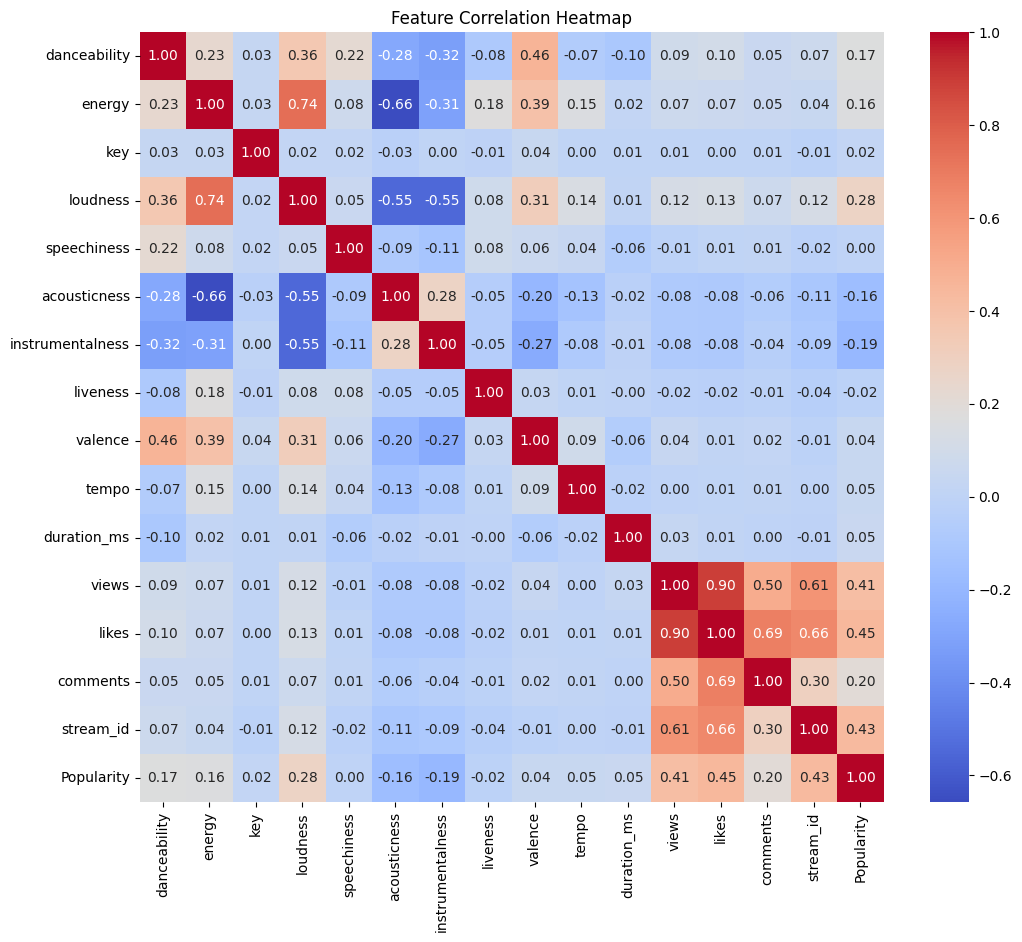

In [14]:
# Calculate the correlation matrix
# Utilize Seaborn to plot the feature correlation heatmap with correlation values displayed.

import matplotlib.pyplot as plt
import seaborn as sns
#plt.ion()
corr_matrix = df_train.corr(numeric_only=True)
# Plot the heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [15]:
categorical_cols

['artist_name',
 'album_name',
 'track_name',
 'spotify_uri',
 'youtube_url',
 'youtube_title',
 'channel',
 'description',
 'licensed',
 'official_video']

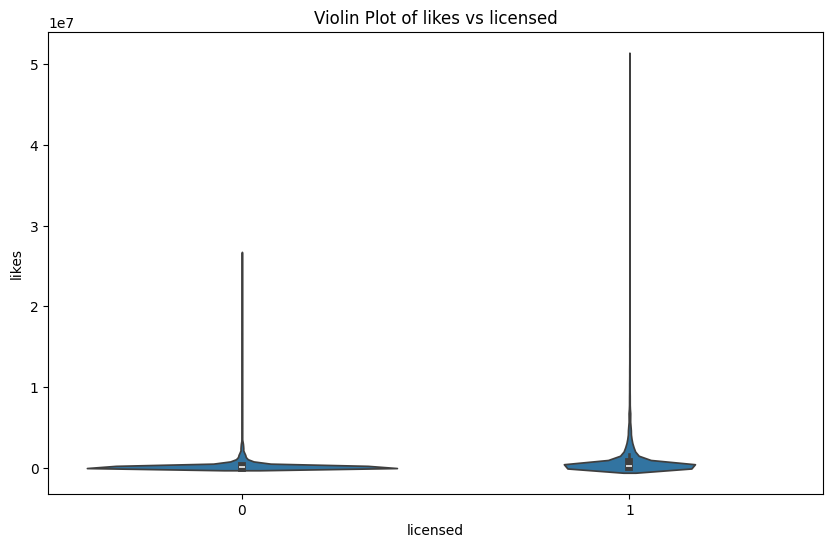

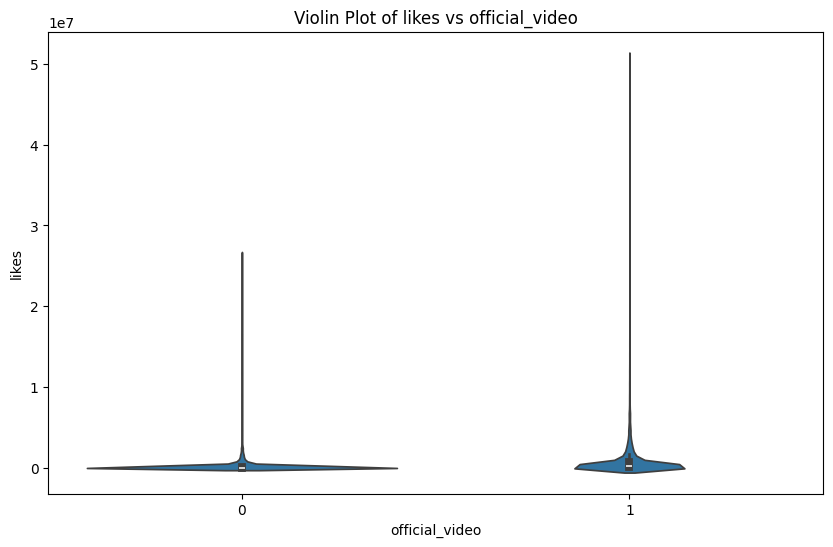

In [17]:
# Display violin plots to demonstrate the correlation between the target value and categorical features.
# # 'artist_name',
#  'album_name',
#  'track_name',
#  'spotify_uri',
#  'youtube_url',
#  'youtube_title',
#  'description',
#  'official_video' - These features have too many values to be displayed directly and are not suitable for violin plots.
selected_columns = ['licensed', 'official_video']
target_column = 'likes'
for col in selected_columns:
    plt.figure(figsize=(10, 6))
    violin_plot = sns.violinplot(x=df_train[col], y=df_train[target_column])
    plt.title(f'Violin Plot of {target_column} vs {col}')
    plt.xlabel(col)
    plt.ylabel(target_column)
    plt.show()


In [ ]:
# Extract meaningful insights from the analysis of categorical and numerical correlation heatmaps.
# 'licensed', 'official_video' are correlated with 'likes'. 'views', 'comments', and 'likes' have a positive correlation, and the correlation is relatively high.


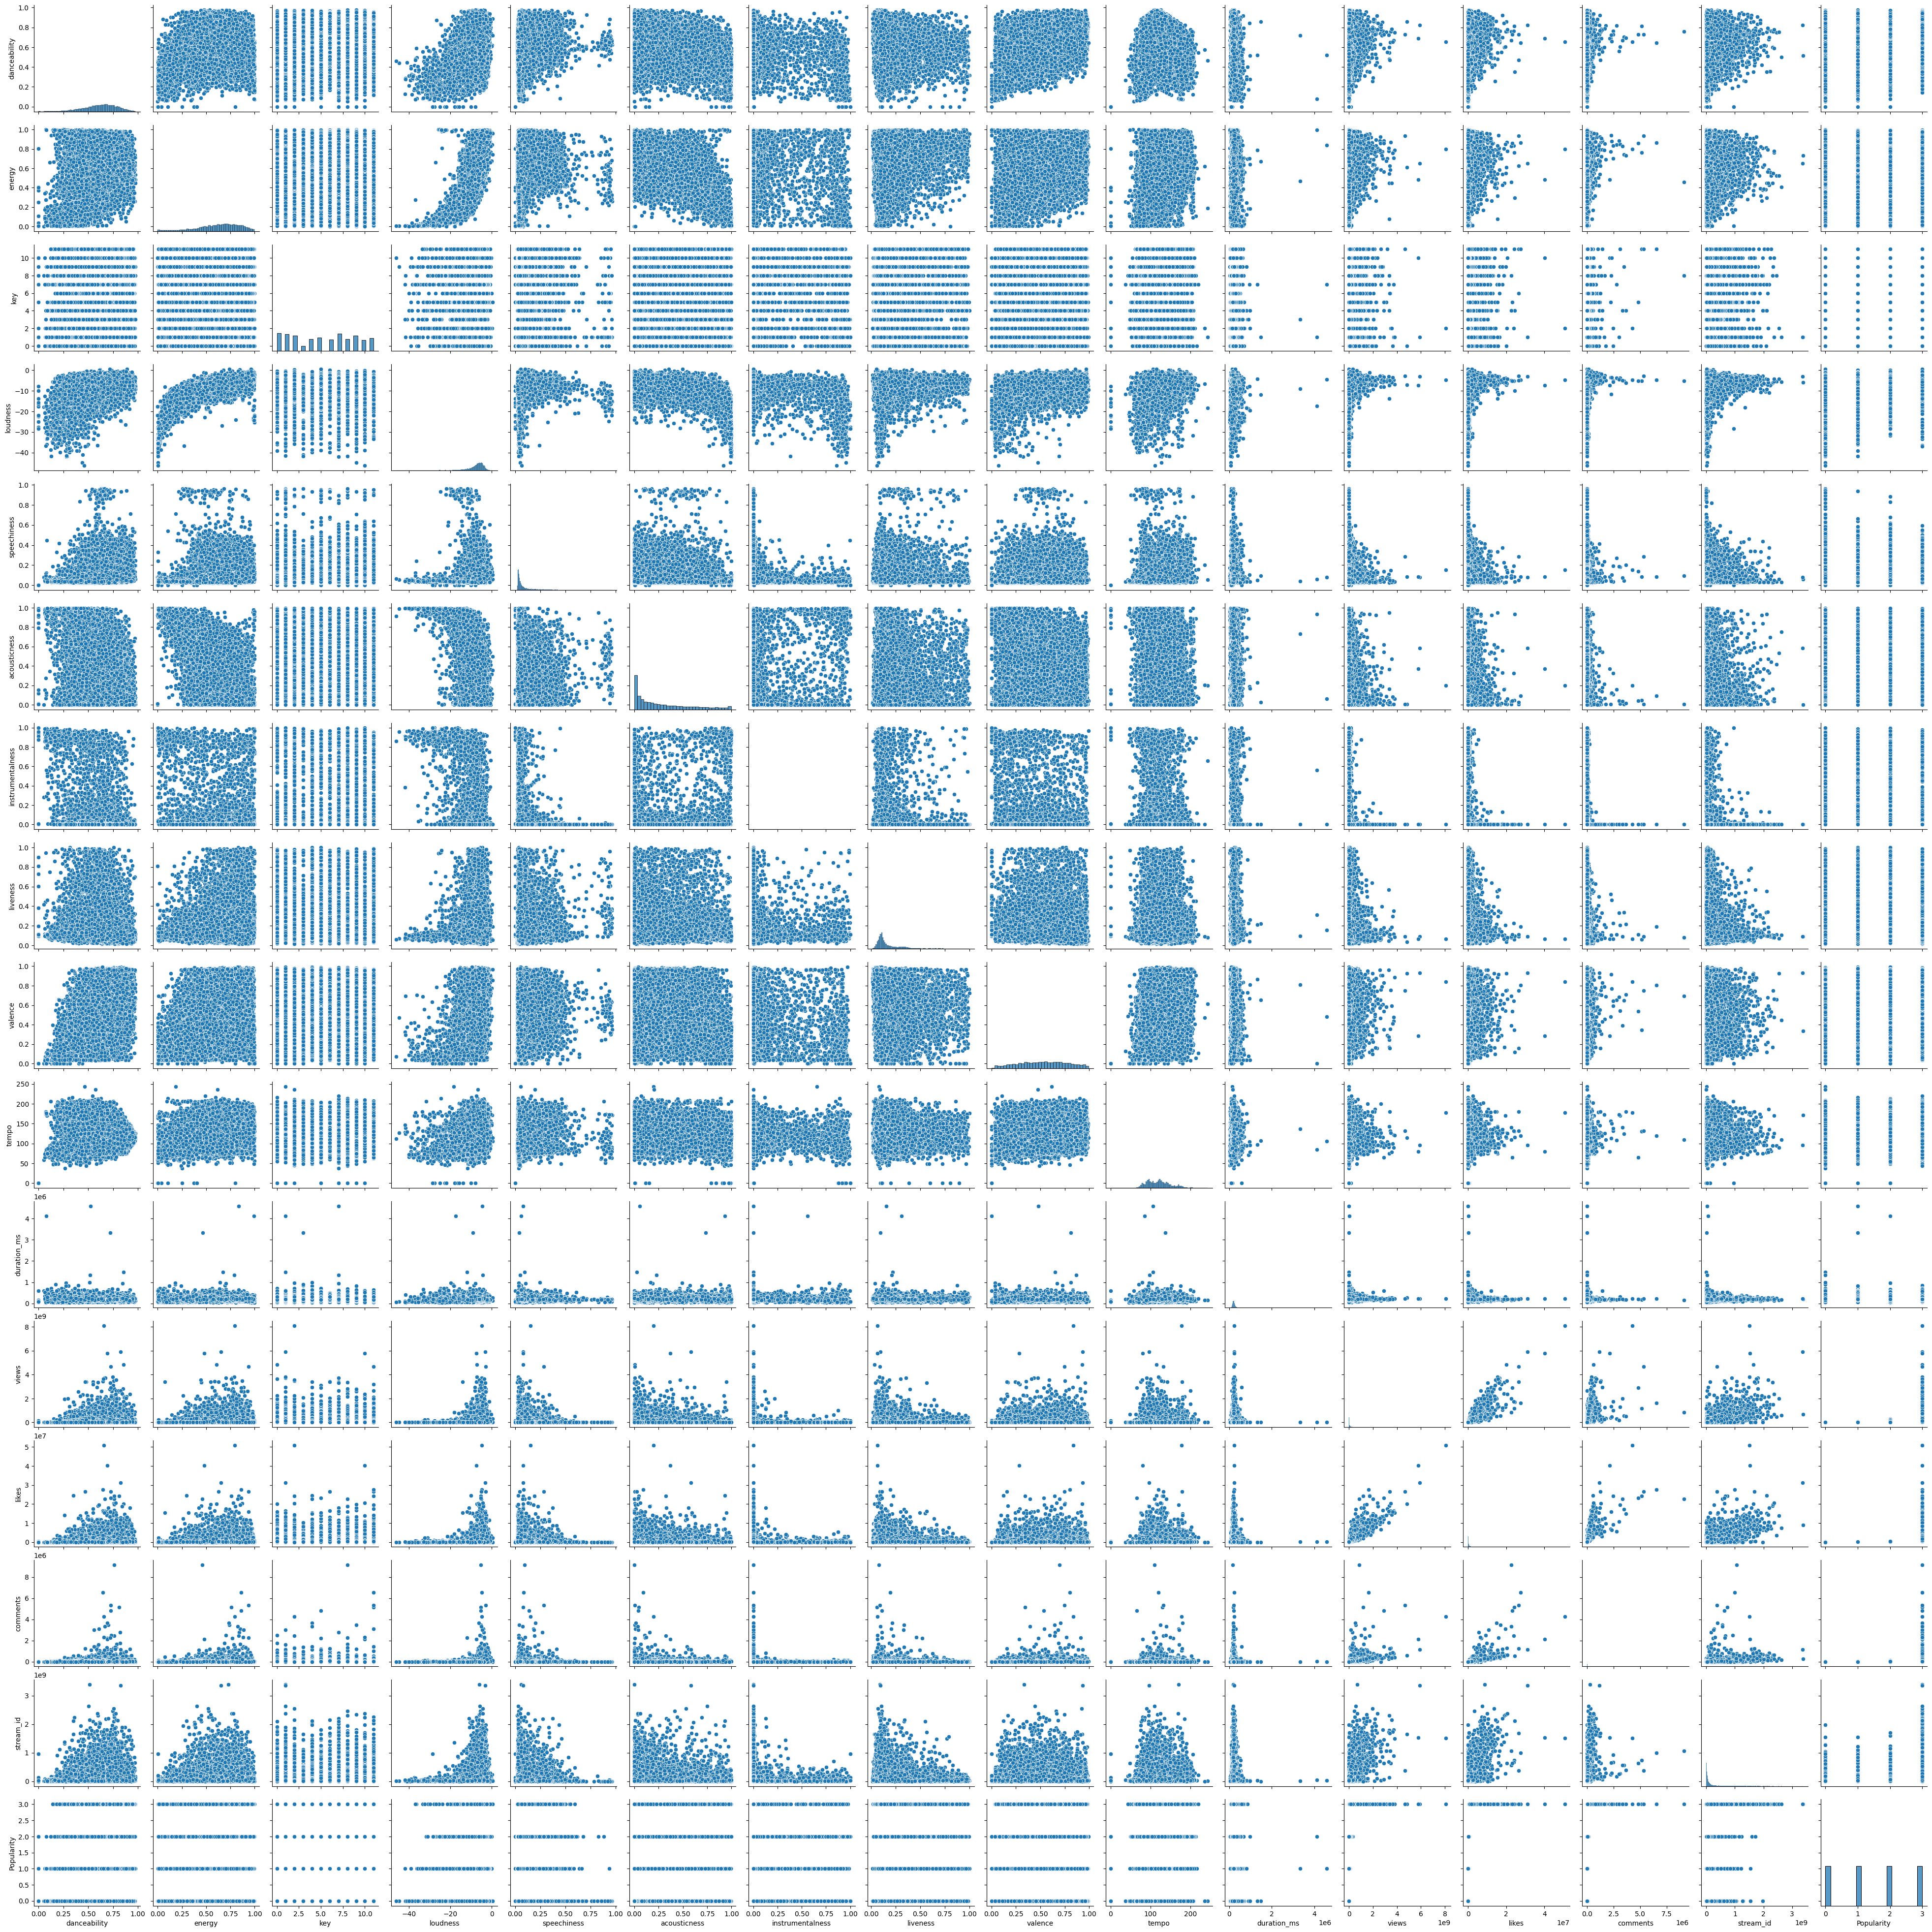

In [18]:
# Examine the distribution of each attribute/feature and derive insightful conclusions from them (3pts).
# The attributes most highly correlated with 'likes' are 'views' and 'comments'.
sns.pairplot(df_train)
plt.show()


In [ ]:
remove_columns = ['artist_name','stream_id','album_name','channel','Popularity',
 'album_name',
 'track_name',
 'spotify_uri',
 'youtube_url',
 'youtube_title',
 'description']

In [ ]:
df_train.drop(columns=remove_columns, inplace=True, errors='ignore')

In [ ]:
numerical_cols.remove('stream_id')
# Popularity
numerical_cols.remove('Popularity')

In [ ]:
# Manage non-normal distributions and detail the strategy for addressing them if necessary.
# set the size of image
for i, feature in enumerate(numerical_cols):
    plt.figure(figsize=(6, 6))
    sns.histplot(df_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

    plt.show()

In [ ]:
df_train.columns

In [ ]:
log_columns = ['duration_ms','views', 'likes', 'comments']
import numpy as np
# apply logarithmic transformation to 'duration_ms', 'views', 'likes', 'comments' to achieve a normal distribution
for col in log_columns:
    df_train[col] = np.log1p(df_train[col])


In [ ]:
for i, feature in enumerate(numerical_cols):
    plt.figure(figsize=(6, 6))
    sns.histplot(df_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

In [ ]:
# # Address null and missing values and explain the strategy for handling them.

df_train.isnull().sum()

In [ ]:
# Implement one-hot encoding for categorical values if required.
# Scale the data.

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# fill missing values in numerical variables with the median, and for categorical variables, use the mode (most frequent value).

class Preprocessor:
    def __init__(self, numerical_features, categorical_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.preprocessor = self._create_preprocessor()

    def _create_preprocessor(self):
        # Define transformers for numerical and categorical features
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine transformers for numerical and categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])

        return preprocessor

    def fit_transform(self, X, y=None):
        return self.preprocessor.fit_transform(X)

    def transform(self, X):
        return self.preprocessor.transform(X)

numerical_features = list(df_train.select_dtypes(include=['int', 'float']).columns)
categorical_features = list(df_train.select_dtypes(include=['object']).columns)

preprocessor = Preprocessor(numerical_features, categorical_features)

processed_data_train = preprocessor.fit_transform(df_train)

processed_df_train = pd.DataFrame(processed_data_train, columns=numerical_features + preprocessor.preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist())

processed_df_train.isnull().sum()

In [ ]:
df_train

In [ ]:
processed_df_train.head()

In [ ]:
df_test.drop(columns=remove_columns, inplace=True, errors='ignore')
processed_data_test = preprocessor.fit_transform(df_test)
processed_df_test = pd.DataFrame(processed_data_test, columns=numerical_features + preprocessor.preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist())
processed_df_test.head()

In [ ]:
processed_df_test.isnull().sum()

# Model Training and Optimization

In [ ]:
#Installing Lazypredict to fetch best performance Models on this dataset
pip install lazypredict-nightly

In [ ]:
# Split data to features and predictors for model training
Y_train = df_train['likes']
X_train = df_train.drop(['likes'], axis=1)

Y_test = df_test['likes']
X_test = df_test.drop(['likes'], axis=1)

In [ ]:
X_train.info()

In [ ]:
# Run different models
from lazypredict import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)
print(models)

In [ ]:
# get numerical and categorical features of the split dataset
num_features = list(X_train.select_dtypes(include=['int', 'float']).columns)
cat_features = list(X_train.select_dtypes(include=['object']).columns)

In [2]:
# Run Random Forest Regressor as baseline model
# Create pipeline with preprocessor and other data manipulation and models
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

rfr = make_pipeline(Preprocessor(num_features, cat_features), RandomForestRegressor())
rfr

NameError: name 'Preprocessor' is not defined

In [ ]:
rfr.fit(X_train, Y_train)

In [ ]:
params = rfr.get_params()
params

In [ ]:
# Select the simplest model and register its metric on the test data, denoting this as the baseline model. (5pts)
from sklearn.metrics import  root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
y_train_hat = rfr.predict(X_train)
rm2e = root_mean_squared_error(Y_train, y_train_hat)
mae = mean_absolute_error(Y_train, y_train_hat)
mse = mean_squared_error(Y_train, y_train_hat)
r2 = r2_score(Y_train, y_train_hat)
print(rm2e, mae, mse, r2)

In [ ]:
y_test_hat = rfr.predict(X_test)
trm2e = root_mean_squared_error(Y_test, y_test_hat)
tmae = mean_absolute_error(Y_test, y_test_hat)
tmse = mean_squared_error(Y_test, y_test_hat)
tr2 = r2_score(Y_test, y_test_hat)
print(trm2e, tmae, tmse, tr2)

In [ ]:
#Install Dagshub to track the experiments
!pip3 install mlflow dagshub


In [ ]:
# Set Dagshub Parameters
import os
MLFLOW_TRACKING_URI = "https://dagshub.com/gitgrumble/Song_Popularity.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'gitgrumble'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '47fd8d05b2d5650f80ea0c986bcbcfb62e07c115'

In [1]:
# Experiment 1 - Register RandomForestRegressor metrics on Dagshub
import dagshub
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Song_Popularity")

# Start an MLflow run
with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(params)

      # Log metrics
      mlflow.log_metric("root_mean_squared_error", trm2e)
      mlflow.log_metric("mean_squared_error", tmse)
      mlflow.log_metric("mean_absolute_error", tmae)
      # mlflow.log_metric("r2", tr2)

      # Set a tag that we can use to remind ourselves what this run was for
      mlflow.set_tag("Training", "RandomForestRegressor baseline model for spotify_youtube data, n_estimators=100")

      # Infer the model signature
      signature = infer_signature(X_train, rfr.predict(X_train))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=rfr,
          artifact_path="SongPopularity_Model",
          signature=signature,
          input_example=X_train,
          registered_model_name="rfr_model_n_estimators=100",
    )




In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

In [ ]:
# Create Pipelines for DecisionTreeRegressor, ExtraTreesREgressor, GradientBoostingRegressor
pipelines = {
    'decisiontree': make_pipeline(Preprocessor(num_features, cat_features), DecisionTreeRegressor()),
    'Extratrees': make_pipeline(Preprocessor(num_features, cat_features), ExtraTreesRegressor()),
    'gradientbooster': make_pipeline(Preprocessor(num_features, cat_features), GradientBoostingRegressor()),

}

In [ ]:
# Fit the models with the training dataset
fit_models = {}
import time
total_start = time.monotonic()
for algo, model in pipelines.items():
  try:
        print(algo)
        start = time.monotonic()
        model.fit(X_train, Y_train)
        fit_models[algo] = model
        end = time.monotonic()
        print(algo, end-start)
  except Exception as e:
        print(f'Model {algo} had an error {e}')

end = time.monotonic()
print(end-total_start)

In [ ]:
fit_models

In [ ]:
# Experiments 2,3,4 - Select the top 3 models and register their baseline scores in MLFlow. (5pts)
# Start an MLflow run
for algo, model in fit_models.items():
  params = model.get_params()
  test_hat = model.predict(X_test)
  rm2e = root_mean_squared_error(Y_test, test_hat)
  mse = mean_squared_error(Y_test, test_hat)
  mae = mean_absolute_error(Y_test, test_hat)

  with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(params)

        # Log metrics
        mlflow.log_metric("root_mean_squared_error", rm2e)
        mlflow.log_metric("mean_squared_error", mse)
        mlflow.log_metric("mean_absolute_error", mae)
        # mlflow.log_metric("r2", tr2)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training", f"BaselineModels {algo}")

        # Infer the model signature
        signature = infer_signature(X_train, model.predict(X_train))

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=rfr,
            artifact_path="SongPopularity_Model",
            signature=signature,
            input_example=X_train,
            registered_model_name=algo,
      )

In [ ]:
grid = {
    'Extratrees':{'extratreesregressor__max_depth':[5, 8, 10, None],
                  'extratreesregressor__n_estimators':[50, 100, 150]},
    'gradientbooster':{
        'gradientboostingregressor__min_samples_leaf':[2,5,8,10],
        'gradientboostingregressor__n_estimators': [50,100,200]
    },
    'decisiontree':{
        'decisiontreeregressor__min_samples_leaf':[4, 5, 6, 9],
        'decisiontreeregressor__max_depth':[3,5,7, None]
    }
}

In [ ]:
# Perform hyperparameter tuning on the top 3 models  (5pts)
from sklearn.model_selection import GridSearchCV
import time
total_start = time.monotonic()
fit_models_hyperpar = {}
for algo, pipeline in pipelines.items():
    try:
        print(algo)
        start = time.monotonic()
        model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=10, scoring = 'r2' )
        model.fit(X_train, Y_train)
        fit_models_hyperpar[algo] = model
        end = time.monotonic()
        print(algo, end-start)
    except Exception as e:
        print(f'Model {algo} had an error {e}')

end = time.monotonic()
print(end-total_start)

In [ ]:
print(fit_models_hyperpar['decisiontree'].best_estimator_[1],fit_models_hyperpar['decisiontree'].best_score_)
print(fit_models_hyperpar['Extratrees'].best_estimator_[1], fit_models_hyperpar['Extratrees'].best_score_)
print(fit_models_hyperpar['gradientbooster'].best_estimator_[1], fit_models_hyperpar['gradientbooster'].best_score_)

In [ ]:
# Experiment 5,6,7 - Record the scores of Hypertuning models in MLFlow.

# Create a new MLflow Experiment
mlflow.set_experiment("SongPopularity_HyperParameterTuning")

# Start an MLflow run
for algo, model in fit_models_hyperpar.items():

  algo_bestmodel = fit_models_hyperpar[algo].best_estimator_
  algo_y_testhat = algo_bestmodel.predict(X_test)
  rm2e = root_mean_squared_error(algo_y_testhat, Y_test)
  mae = mean_absolute_error(algo_y_testhat, Y_test)
  mse = mean_squared_error(algo_y_testhat, Y_test)
  params = model.best_params_
  with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(params)

      # Log metrics
      mlflow.log_metric("root_mean_squared_error", rm2e)
      mlflow.log_metric("mean_squared_error", mse)
      mlflow.log_metric("mean_absolute_error", mae)
      # mlflow.log_metric("r2", score)

      # Infer the model signature
      signature = infer_signature(X_train, model.best_estimator_.predict(X_train))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=model,
          artifact_path="SongPopularity_Model",
          signature=signature,
          input_example=X_train,
          registered_model_name=algo,
      )

In [ ]:
# Drop features based on feature_importance provided by most models.
# feature_importances for DecisionTreeRegressor Model
dt_bestmodel = fit_models_hyperpar['decisiontree'].best_estimator_[1]
featured_cols_dt = []
for score, name in sorted(zip(dt_bestmodel.feature_importances_, list(X_test.columns)), reverse=True):
    print(round(score, 3), name)
    if name not in featured_cols_dt:
      featured_cols_dt.append(name)


In [ ]:
dt_num_fts = ['views','comments','duration_ms']
dt_cat_fts = ['licensed']

In [ ]:
dt_featureimp = make_pipeline(Preprocessor(dt_num_fts, dt_cat_fts), DecisionTreeRegressor())
dt_model = dt_featureimp.fit(X_train, Y_train)
dt_fimp_testhat = dt_model.predict(X_test)
dt_fimp_rm2e = root_mean_squared_error(Y_test, dt_fimp_testhat)
dt_fimp_mse = mean_squared_error(Y_test, dt_fimp_testhat)
dt_fimp_mae = mean_absolute_error(Y_test, dt_fimp_testhat)

In [ ]:
# feature_importances for ExtraTreesRegressor Model
classifier = fit_models_hyperpar['Extratrees'].best_estimator_[1]
for score, name in sorted(zip(classifier.feature_importances_, list(X_test.columns)), reverse=True):
    print(round(score, 4), name)

In [ ]:
et_num_cols = ['views', 'comments', 'speechiness', 'duration_ms']
et_cat_cols = ['licensed']
et_featureimp = make_pipeline(Preprocessor(et_num_cols, et_cat_cols), ExtraTreesRegressor())
et_model = et_featureimp.fit(X_train, Y_train)
et_fimp_testhat = et_model.predict(X_test)
et_fimp_rm2e = root_mean_squared_error(Y_test, et_fimp_testhat)
et_fimp_mse = mean_squared_error(Y_test, et_fimp_testhat)
et_fimp_mae = mean_absolute_error(Y_test, et_fimp_testhat)

In [ ]:
# feature_importances for GradientBoostingRegressor Model
classifier = fit_models_hyperpar['gradientbooster'].best_estimator_[1]
for score, name in sorted(zip(classifier.feature_importances_, list(X_test.columns)), reverse=True):
    print(round(score, 4), name)

In [ ]:
gb_num_cols = ['views', 'comments', 'speechiness', 'duration_ms']
gb_cat_cols = ['licensed']
gb_featureimp = make_pipeline(Preprocessor(gb_num_cols, gb_cat_cols), GradientBoostingRegressor())
gb_model = gb_featureimp.fit(X_train, Y_train)
gb_fimp_testhat = gb_model.predict(X_test)
gb_fimp_rm2e = root_mean_squared_error(Y_test, gb_fimp_testhat)
gb_fimp_mse = mean_squared_error(Y_test, gb_fimp_testhat)
gb_fimp_mae = mean_absolute_error(Y_test, gb_fimp_testhat)

In [ ]:
feature_imp_pipelines = {'decisiontree' : make_pipeline(Preprocessor(dt_num_fts, dt_cat_fts), DecisionTreeRegressor()),
                         'Extratrees' : make_pipeline(Preprocessor(et_num_cols, et_cat_cols), ExtraTreesRegressor()),
                         'gradientbooster': make_pipeline(Preprocessor(gb_num_cols, gb_cat_cols), GradientBoostingRegressor())}

In [ ]:
for algo,model in feature_imp_pipelines.items():
  model.fit(X_train, Y_train)

In [ ]:
# Experiment 8, 9, 10 - Run experiments with a limited number of features and register them in MLFlow.
# Start an MLflow run
for algo, model in feature_imp_pipelines.items():
  params = model.get_params()
  test_hat = model.predict(X_test)
  rm2e = root_mean_squared_error(Y_test, test_hat)
  mse = mean_squared_error(Y_test, test_hat)
  mae = mean_absolute_error(Y_test, test_hat)

  with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(params)

        # Log metrics
        mlflow.log_metric("root_mean_squared_error", rm2e)
        mlflow.log_metric("mean_squared_error", mse)
        mlflow.log_metric("mean_absolute_error", mae)
        # mlflow.log_metric("r2", tr2)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training", f"Feature Importances {algo}")

        # Infer the model signature
        signature = infer_signature(X_train, model.predict(X_train))

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=rfr,
            artifact_path="SongPopularity_Model",
            signature=signature,
            input_example=X_train,
            registered_model_name=f'{algo} Feature Importances',
      )

In [ ]:
# Combining Features
ft1 = X_train['danceability']*X_train['energy']
ft2 = X_train['duration_ms']*X_train['loudness']
X_train_new = df_train.drop(['danceability','energy', 'duration_ms', 'loudness', 'official_video', 'likes'], axis=1)
cf_num_cols = list(X_train_new.select_dtypes(include=['int', 'float']).columns)
cf_cat_cols = list(X_train_new.select_dtypes(include=['object']).columns)

cf_num_cols.extend(['ft1', 'ft2'])
X_train_new['ft1'] = ft1
X_train_new['ft2'] = ft2

X_test_new = df_test.drop(['danceability','energy', 'duration_ms', 'loudness', 'official_video', 'likes'], axis=1)
ft1 = X_test['danceability']*X_test['energy']
ft2 = X_test['duration_ms']*X_test['loudness']
X_test_new['ft1'] = ft1
X_test_new['ft2'] = ft2


In [ ]:
X_train_new.head()

In [ ]:
et_combfeat_model = make_pipeline(Preprocessor(cf_num_cols, cf_cat_cols), ExtraTreesRegressor())
et_combfeat_model.fit(X_train, Y_train)
et_combfeat_params = et_combfeat_model.get_params()
et_cf_test_hat = et_combfeat_model.predict(X_test)
et_cf_rm2e = root_mean_squared_error(Y_test, et_cf_test_hat)
et_cf_mse = mean_squared_error(Y_test, et_cf_test_hat)
et_cf_mae = mean_absolute_error(Y_test, et_cf_test_hat)

In [3]:
# Experiment 11 - Run experiments on combined features and record them in MLFlow.
# Start an MLflow run
with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(et_combfeat_params)

      # Log metrics
      mlflow.log_metric("root_mean_squared_error", et_cf_rm2e)
      mlflow.log_metric("mean_squared_error", et_cf_mse)
      mlflow.log_metric("mean_absolute_error", et_cf_mae)
      # mlflow.log_metric("r2", tr2)

      # Set a tag that we can use to remind ourselves what this run was for
      mlflow.set_tag("Training", "Combining Features")

      # Infer the model signature
      signature = infer_signature(X_train, et_combfeat_model.predict(X_train))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=rfr,
          artifact_path="SongPopularity_Model",
          signature=signature,
          input_example=X_train,
          registered_model_name="Combined_Features",
    )

NameError: name 'mlflow' is not defined

In [ ]:
# Generate New features by utilizing PCA.
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_model = make_pipeline(Preprocessor(num_features, cat_features), pca, ExtraTreesRegressor())
# pca_model
X_pca = pca_model.fit(X_train, Y_train)

In [ ]:
pca_testhat = X_pca.predict(Y_test)
pca_rm2e = root_mean_squared_error(Y_test, pca_testhat)
pca_mse = mean_squared_error(Y_test, pca_testhat)
pca_mae = mean_absolute_error(Y_test, pca_testhat)
pca_params = X_pca.get_params()


In [ ]:
# Experiment 12 -Run experiments on PCA and record them in MLFlow.
# Start an MLflow run
with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(pca_params)

      # Log metrics
      mlflow.log_metric("root_mean_squared_error", pca_rm2e)
      mlflow.log_metric("mean_squared_error", pca_mse)
      mlflow.log_metric("mean_absolute_error", pca_mae)
      # mlflow.log_metric("r2", tr2)

      # Set a tag that we can use to remind ourselves what this run was for
      mlflow.set_tag("Training", "PCA Feature Engineering")

      # Infer the model signature
      signature = infer_signature(X_train, X_pca.predict(X_train))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=rfr,
          artifact_path="SongPopularity_Model",
          signature=signature,
          input_example=X_train,
          registered_model_name="PCA ExtraTrees Regressor",
    )